#Data Preparation and Exploratory Data Analysis

##Objectives
1. Load and examine the retail sales data
2. Handle missing values and data quality issues
3. Perform exploratory data analysis (EDA)
4. Engineer features for time series forecasting
5. Prepare data for modeling  

**Step 1 : Environment Setup & Data Insights**

In [16]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller


In [17]:
#Load Data
# Import Google Colab file directory
from google.colab import drive
drive.mount('/content/drive')
file_train = '/content/drive/MyDrive/train.csv'
file_oil = '/content/drive/MyDrive/oil.csv'
file_holidays = '/content/drive/MyDrive/holidays_events.csv'
file_stores = '/content/drive/MyDrive/stores.csv'
file_items = '/content/drive/MyDrive/items.csv'

train = pd.read_csv(file_train, parse_dates=['date'])
display(train.head())

oil = pd.read_csv(file_oil, parse_dates=['date'])
display(oil.head())

holidays = pd.read_csv(file_holidays, parse_dates=['date'])
display(holidays.head())

stores = pd.read_csv(file_stores)
display(stores.head())

items = pd.read_csv(file_items)
display(items.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,34,165704,2015-11-04,61162432.0,1.0,False,2015,11,4,2,5.714286
1,34,938566,2016-10-14,93853940.0,15.0,False,2016,10,14,4,19.714286
2,35,1159415,2015-06-23,49691210.0,10.0,False,2015,6,23,1,6.285714
3,32,168931,2015-03-22,43369242.0,1.0,False,2015,3,22,6,1.714286
4,36,1919933,2016-07-15,85079911.0,2.0,False,2016,7,15,4,10.142857


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


**`Notes:`**
* The original largetrain.csv was ~5GB. The train.csv we are loading is the result of:
  * Geographic Filter: Only 'Guayas' region stores.
  * Family Filter: Only the Top 3 product families (Grocery I, Beverages, Cleaning).
  * Sampling: A 300,000 row slice to ensure computational efficiency.
* For the initial EDA and Preprocessing, we focus primarily on the train dataset. This is because train.csv contains our Target Variable (unit_sales). The other datasets (oil, holidays, stores, etc.) provide context and will be merged later as Exogenous Regressors once our primary daily sales timeline is stabilized and aggregated



In [18]:
# Display basic information
print("Dataset Information:\n")
train.info()

# Display statistical summary
print("\nStatistical Summary:\n")
display(train.describe())



Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   store_nbr          300000 non-null  int64         
 1   item_nbr           300000 non-null  int64         
 2   date               300000 non-null  datetime64[ns]
 3   id                 300000 non-null  float64       
 4   unit_sales         300000 non-null  float64       
 5   onpromotion        300000 non-null  bool          
 6   year               300000 non-null  int64         
 7   month              300000 non-null  int64         
 8   day                300000 non-null  int64         
 9   day_of_week        300000 non-null  int64         
 10  unit_sales_7d_avg  299400 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(6)
memory usage: 23.2 MB

Statistical Summary:



,store_nbr,item_nbr,date,id,unit_sales,year,month,day,day_of_week,unit_sales_7d_avg
count,300000.000000,3.000000e+05,300000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,299400.000000
mean,32.444370,9.024621e+05,2015-08-30 03:15:57.024000,6.152516e+07,6.851231,2015.177800,6.327260,15.622280,3.055307,6.245573
min,24.000000,9.699500e+04,2013-01-02 00:00:00,1.886100e+04,0.391000,2013.000000,1.000000,1.000000,0.000000,-3.714286
25%,27.000000,4.210660e+05,2014-08-28 00:00:00,2.979787e+07,2.000000,2014.000000,3.000000,8.000000,1.000000,1.571429
50%,30.000000,8.860670e+05,2015-11-01 00:00:00,6.086938e+07,3.000000,2015.000000,6.000000,16.000000,3.000000,3.142857
75%,35.000000,1.209720e+06,2016-10-06 00:00:00,9.308607e+07,7.000000,2016.000000,9.000000,23.000000,5.000000,6.428571
max,51.000000,2.127114e+06,2017-08-15 00:00:00,1.254915e+08,3828.000000,2017.000000,12.000000,31.000000,6.000000,4708.285714
std,7.846089,5.241451e+05,NaN,3.641892e+07,19.382867,1.311284,3.389387,8.838783,2.023235,14.777134


Insights:
* Highly Skewed Data: The average sales are 6.8 units, but the maximum is 3,828. This shows that most items sell in small amounts, while a few have extreme volume spikes.
* No Returns Found: The minimum sale is positive (0.39). This confirms the dataset does not contain negative values (returns), so no cleaning for "returned items" is needed.
* Timeline Confirmed: Dates range from Jan 2013 to Aug 2017 (~4.5 years). This is a sufficient duration to capture multiple yearly seasonal cycles (e.g., Christmas).
* Regional Focus: Store numbers range from 24 to 51, confirming our filter successfully narrowed the data to the specific Guayas region.
* Feature Discrepancy: The pre-calculated unit_sales_7d_avg has a negative minimum (-3.7). Since physical sales can't be negative, we must perform our own aggregation to ensure accuracy.

In [19]:
# Check Missing Values
train.isnull().sum()

,0
store_nbr,0
item_nbr,0
date,0
id,0
unit_sales,0
onpromotion,0
year,0
month,0
day,0
day_of_week,0


Insights:

while the core columns (date, unit_sales, store_nbr) are complete, the column unit_sales_7d_avg has 600 missing values.In time-series analysis, calculating a 7-day average requires the previous 7 days of data to be present. The fact that these are missing suggests that the first few days of the dataset or certain gaps in the timeline were not handled correctly in the pre-calculated features. This confirms that we cannot rely on the existing features and must perform our own aggregation and feature engineering to ensure a 100% complete and accurate dataset.

In [20]:
# Check the date range
min_date = train['date'].min()
max_date = train['date'].max()
expected_days = (max_date - min_date).days + 1
actual_days = train['date'].nunique()

print(f"Date Range: {min_date.date()} to {max_date.date()}")
print(f"Total rows in sample: {len(train)}")
print(f"Expected number of days: {expected_days}")
print(f"Actual unique days: {actual_days}")
print(f"Missing days: {expected_days - actual_days}")

# Identify the specific missing dates
full_range = pd.date_range(start=min_date, end=max_date, freq='D')
missing_dates = full_range.difference(train['date'])
print("\nDates missing from the dataset:")
print(missing_dates)

Date Range: 2013-01-02 to 2017-08-15
Total rows in sample: 300000
Expected number of days: 1687
Actual unique days: 1680
Missing days: 7

Dates missing from the dataset:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-01-01', '2015-12-25',
               '2016-01-01', '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', freq=None)


Insights:
* We have 300,000 rows but only 1,680 unique days. This means that there are multiple entries for every single date(because this data is 'transactional'—it records different items being sold in different stores on the same day). To perform a time-series forecast, we must simplify this into one total sales number per day(daily_sales).
* The analysis reveals 7 missing days within our 4.5-year timeframe(2013-2017), specifically Christmas and New Year’s Day.This confirms that the Favorita stores in the Guayas region were closed on these major holidays. Because no transactions was made, no rows were generated in the original database.
* For time-series models (like ARIMA or Prophet), these gaps are 'invisible holes.' If we don't fill them, the model will assume December 26th follows December 24th directly, which shifts the weekly seasonality and leads to inaccurate forecasts.
* Solution: we will aggregate the sales and manually insert these 7 missing dates with a value of 0.


**Step 2 : Data Cleaning & Preparation**

In [21]:
# Aggregate to daily totals
daily_sales = train.groupby('date')[['unit_sales']].sum().reset_index()

# Fix the 7 missing dates (The Gap Fix)
full_range = pd.date_range(start=daily_sales['date'].min(), end=daily_sales['date'].max(), freq='D')
daily_sales = daily_sales.set_index('date').reindex(full_range).fillna(0).reset_index()
daily_sales.columns = ['date', 'total_sales']

In [22]:
# Quick check
print(f"Total days in dataset: {len(daily_sales)}")

Total days in dataset: 1687


1687 are the same as 'expected number of days' in dataset, which mean we have no missing dates.

**Step 3 : Exploratory Data Analysis**

3.1 : Primary Time Series Visualization

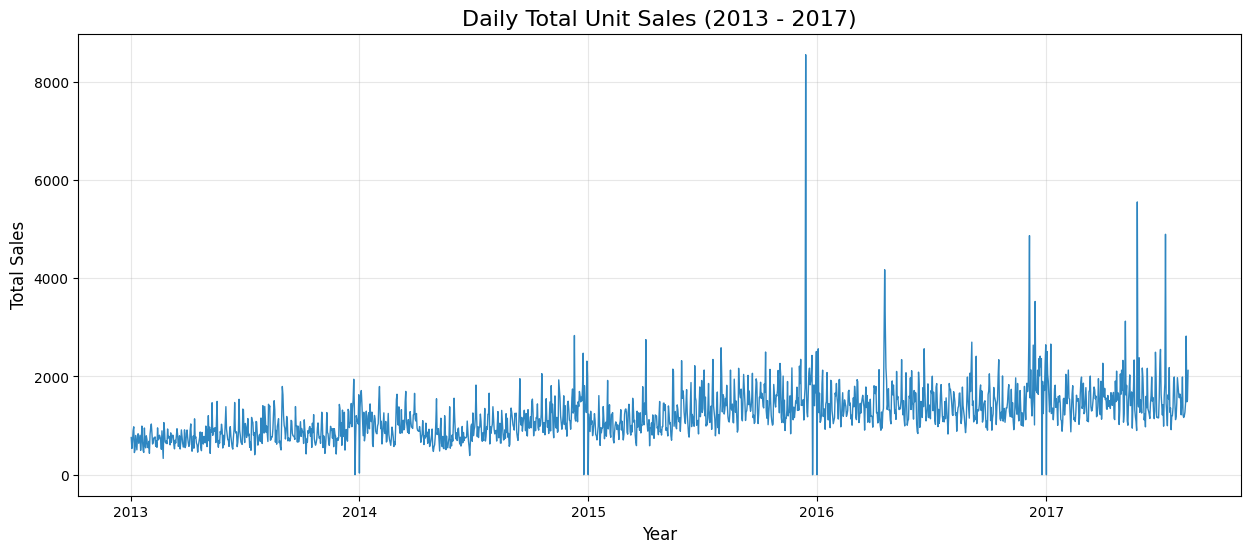

In [23]:
# Create Daily Sales lineplot
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['total_sales'], color='#2E86C1', linewidth=1)
plt.title('Daily Total Unit Sales (2013 - 2017)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Insights:

* Growth & Seasonality: The data shows a steady upward trend from 2013 to 2017, alongside consistent pattern (seasonality) especially during year end.
* Holiday Closures: The sharp drops to zero at the end of each year confirm the store closures on Christmas and New Year’s Day. Since we have filled our missing dates with 0, these are correctly represented as zero-sales days.
* The 2016 Ecuador Earthquake: The high spike in April 2016 is an outlier caused by the 7.8 magnitude earthquake in Equador on April 16th. This represents a surge in emergency demand for essentials rather than typical shopping behavior.The earthquake event was combined together with other holidays and events in the holidays_events dataset.
* We noticed that the holiday spike at the end of 2015 is significantly larger than in previous years. This is likely due to the overall growth of the business over the 4.5-year period. However, we still treat December as a recurring seasonal event.

Modeling Strategy:

To handle these complexities, we will evaluate three approaches:
* Prophet: To account for the yearly growth, weekly cycles, and unique events like holidays so they don't bias seasonal patterns.
* ARIMA: To capture the mathematical "memory" (autocorrelation) and see how long shocks take to stabilize.
* XGBoost: To test if a machine-learning approach can better map non-linear spikes to external factors like holidays or disasters.



3.2 : Distribution Analysis

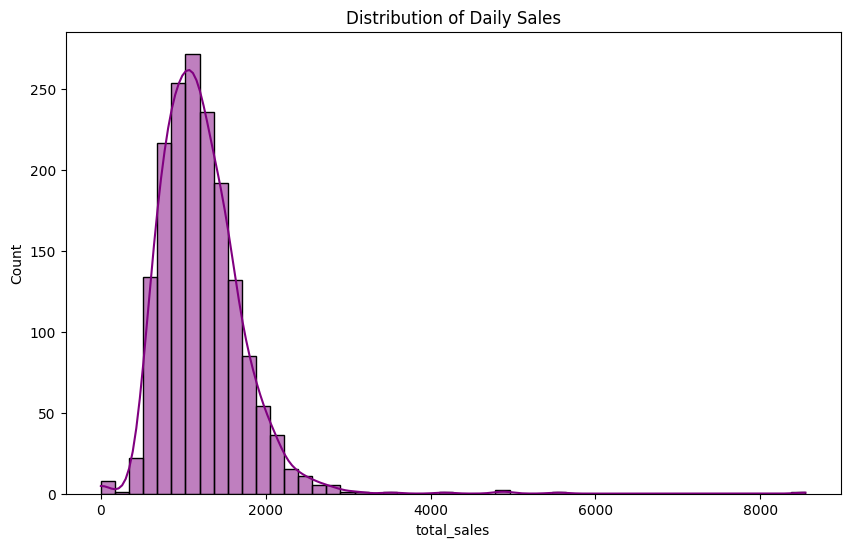

In [24]:
# Create Daily Sales Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(daily_sales['total_sales'], bins=50, kde=True, color='purple')
plt.title('Distribution of Daily Sales')
plt.show()

Insights:
* Right-Skewed Distribution: The "tail" of the graph stretches far to the right, showing that while most days have moderate sales, there are rare days with extreme volume (up to 8,000+ units).
* The "Typical" Day: The highest peak (the mode) sits between 1,000 and 1,500 units, which represents the standard daily operating level for these stores.
* The Zero-Sales Gap: The tiny bar at the far left (near 0) confirms our earlier discovery of store closures on Christmas and New Year's Day.
* Outlier Impact: The extreme values on the far right correspond to the 2015 Holiday peak and the 2016 Earthquake response we saw in the line chart.
* Preprocessing Hint: Because the data isn't a "Bell Curve" (Normal Distribution), we may need to use Log Transformation to stabilize the variance before feeding it into models like ARIMA.

3.3 : Weekly Seasonality Analysis

/tmp/ipython-input-746078970.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='total_sales', data=daily_sales, order=day_order, palette='viridis')


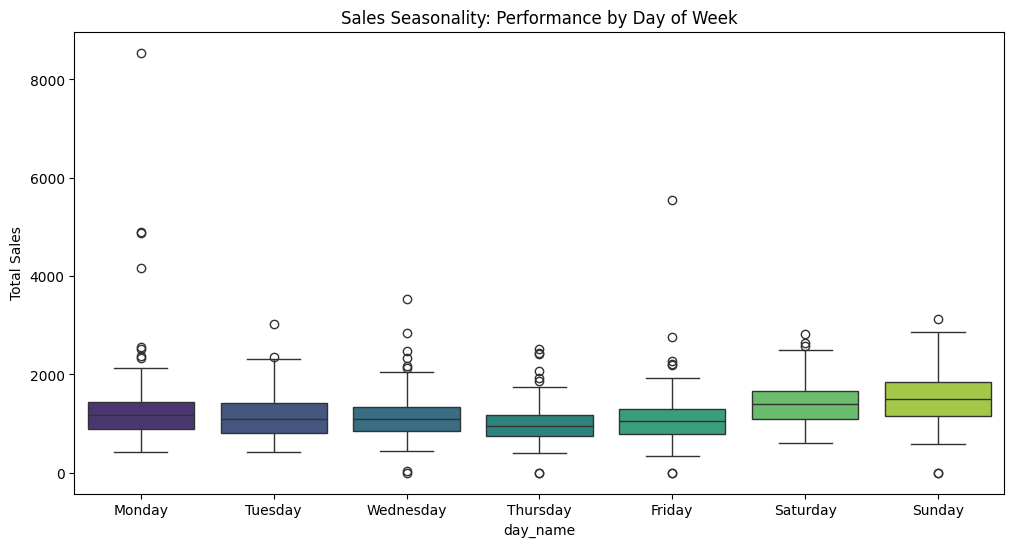

In [25]:
# Extract name of day from the date column & define logical sequence
daily_sales['day_name'] = daily_sales['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='total_sales', data=daily_sales, order=day_order, palette='viridis')
plt.title('Sales Seasonality: Performance by Day of Week')
plt.ylabel('Total Sales')
plt.show()

Insights:

* Clear Weekend Seasonality: Median sales significantly increase on Saturday and Sunday. This confirms that the store experiences predictable, high-volume traffic during the weekend.
* The Monday Outlier: Interestingly, the single highest sales day in the entire dataset (8,000+ units) occurred on a Monday. While Mondays are typically slower, this extreme anomaly suggests a specific one-time event that defied the normal weekly rhythm.
* Stable Core Operations: The "boxes" (the interquartile range) are consistent across the week. This indicates that while outliers exist, the baseline consumer demand is stable and predictable from day to day.
* Validation of Store Closures: The data points sitting at zero on Sunday,Wednesday, Thursday, and Friday confirm our earlier finding regarding Christmas and New Year's closures.

3.4 : Trend Identification via Moving Averages

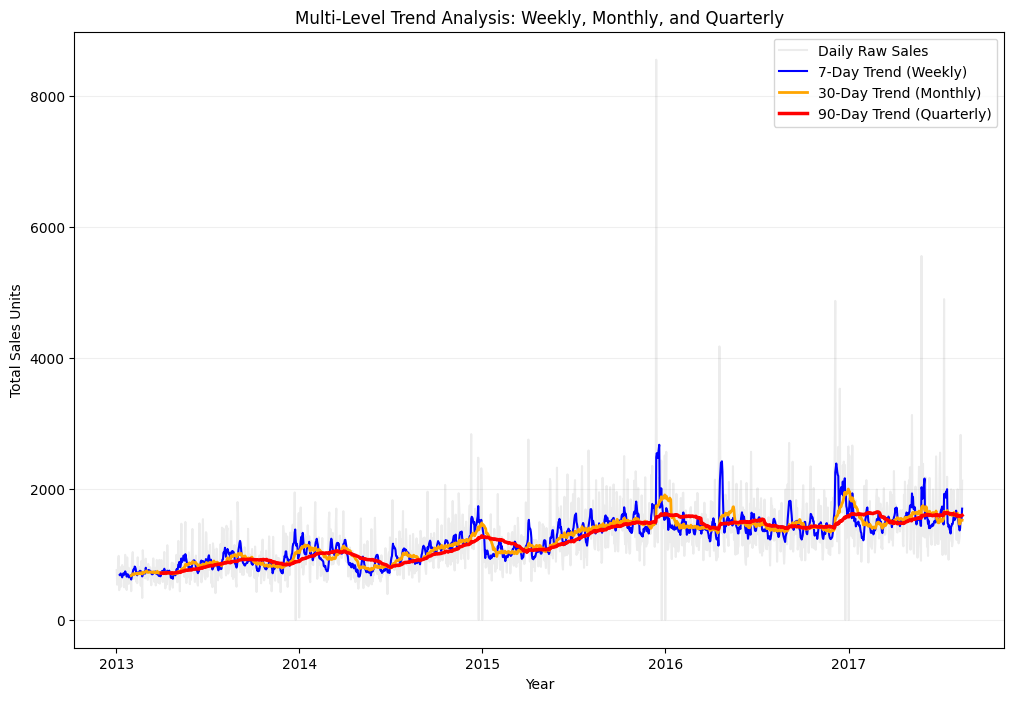

In [26]:
# Calculate rolling averages: 7-day (Weekly), 30-day (Monthly), and 90-day (Quarterly)
daily_sales['MA7'] = daily_sales['total_sales'].rolling(window=7).mean()
daily_sales['MA30'] = daily_sales['total_sales'].rolling(window=30).mean()
daily_sales['MA90'] = daily_sales['total_sales'].rolling(window=90).mean()

# Plot Raw Sales
plt.figure(figsize=(12, 8))
plt.plot(daily_sales['date'], daily_sales['total_sales'], alpha=0.15, label='Daily Raw Sales', color='gray')

# Plot the three trend lines to show different levels of smoothing
plt.plot(daily_sales['date'], daily_sales['MA7'], label='7-Day Trend (Weekly)', linewidth=1.5, color='blue')
plt.plot(daily_sales['date'], daily_sales['MA30'], label='30-Day Trend (Monthly)', linewidth=2, color='orange')
plt.plot(daily_sales['date'], daily_sales['MA90'], label='90-Day Trend (Quarterly)', linewidth=2.5, color='red')

plt.title('Multi-Level Trend Analysis: Weekly, Monthly, and Quarterly')
plt.xlabel('Year')
plt.ylabel('Total Sales Units')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.show()

Insights:
* Consistent Growth: The 90-day trend (red line) filters out daily noise to show a clear upward direction. From 2013 to 2017, the store's baseline sales volume nearly doubled.
* Weekly vs. Daily Impact: While the 2015 "Monday Mystery" spike was extreme, the 7-day trend (blue line) shows it was part of a broader high-volume week rather than a single isolated event.
* Earthquake Impact: The notable rise in the blue line during April 2016 confirms that the earthquake caused a sustained increase in sales rather than a single-day event. This reflects a period of heightened demand as consumers prioritized purchasing essential goods.
* Seasonal Lows: Recurring sales drops at the start of each year represent a standard post-holiday contraction. Recognizing these January shifts helps the model avoid over-predicting after the December peak.

3.5 : External Factor Correlation (Oil Prices)

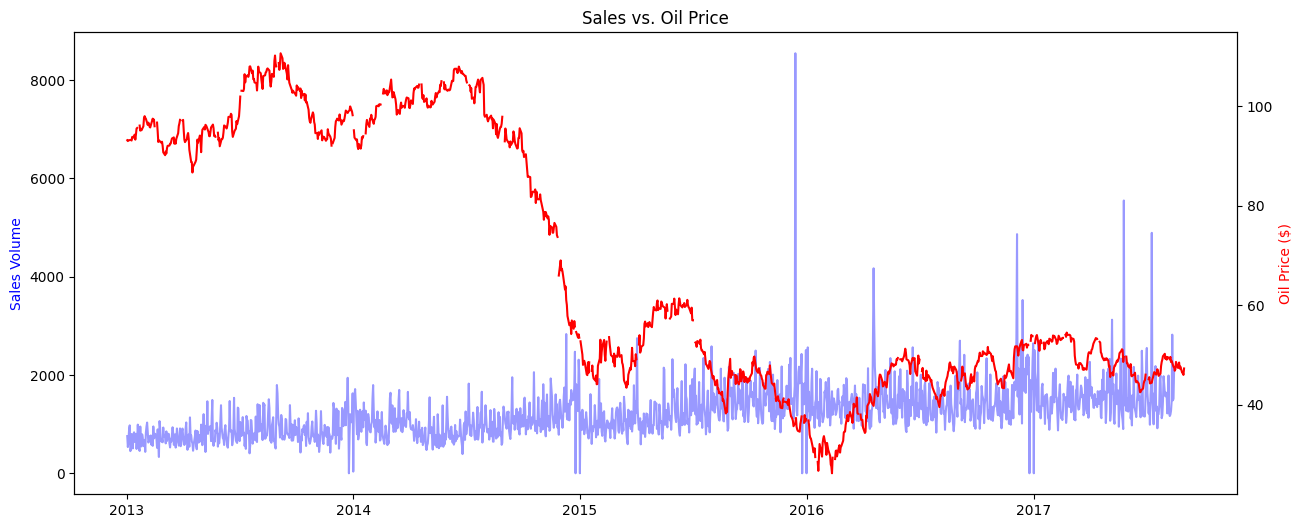

In [27]:
# Create a dual-axis plot to compare Sales Volume vs. Oil Price
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot store sales on the left Y-axis
ax1.plot(daily_sales['date'], daily_sales['total_sales'], color='blue', alpha=0.4, label='Sales')
ax1.set_ylabel('Sales Volume', color='blue')

# Create a right Y-axis for Oil Prices
ax2 = ax1.twinx()
ax2.plot(oil['date'], oil['dcoilwtico'], color='red', label='Oil Price', linewidth=1.5)
ax2.set_ylabel('Oil Price ($)', color='red')

plt.title('Sales vs. Oil Price')
plt.show()

Insights:
* Oil prices do not have a direct, immediate influence on sales.
* Stable Growth Despite Market Drops: Even when oil prices fell in late 2014 - early 2015, retail sales kept increasing. This shows that consumer demand at these stores remained strong despite the external economic downturn.
* Independent Trends: The fact that sales and oil prices did not move together suggests that daily grocery needs are more influenced by local factors than by global commodity markets.
* Identifying the Cause of Spikes: Because the record sales in April 2016 happened while oil prices were at a low point, we can confirm the surge was due to the earthquake rather than an improvement in the economy.

note: as oil is the primary driver of Ecuador’s economy, we check these prices to see if national financial health dictates store performance.

3.6 : Data Final Audit

In [28]:
# Check for any remaining null values in the entire dataset
print(daily_sales.isnull().sum())

date            0
total_sales     0
day_name        0
MA7             6
MA30           29
MA90           89
dtype: int64


* The count shows zero missing values for the date and total_sales columns, confirming the foundational dataset is complete.
* The missing values in the moving average columns (6, 29, and 89) are expected, these represent the initial days required for each window (7, 30, and 90 days) to calculate its first average.

**Step 4 : Export Clean Data**

In [29]:
drive.mount('/content/drive')

# Save directly into a folder in your Drive
path = '/content/drive/My Drive/final_cleaned_sales_data.csv'
daily_sales.to_csv(path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
